# How to Aggregate Textual Responses via Crowdsourcing

Welcome to this tutorial!

We will look at how to apply aggregation methods to a text response and learn from noisy texts in the crowdsourcing setting.

## Libraries importing

First of all, let's install all the necessary libraries:

In [1]:
%%capture
%pip install pandas
%pip install crowd-kit
%pip install sentence_transformers
%pip install jiwer

So, we want somehow to get one correct answer from the several textual responses. Let's deal with that problem with Crowd-Kit library and see what we can do with it

In [2]:
import torch
from jiwer import wer
from sentence_transformers import SentenceTransformer

from crowdkit.aggregation import ROVER, TextHRRASA, TextRASA
from crowdkit.datasets import load_dataset

## Boosting with cuda

We are going to use some machine learning models and for faster calculating it's better to use GPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data preparation

The **load_dataset** function returns a pair of elements. The first element is the pandas data frame with the crowdsourced data. The second element is the ground truth dataset, whenever possible. The data frame, or df, has three columns: **worker**, **task**, and **label**. The label is set to 0 if the document is rated as non-relevant by the given annotator in the given task, otherwise, the label will be 1. The ground truth dataset df_gt is a pandas series that contains the correct responses to the tasks put to the index of this series.

In [68]:
df, gt = load_dataset("crowdspeech-test-clean")

gt = gt.sort_index()
df["text"] = df["text"].str.lower()

Checking our dataset

In [5]:
df.head()

,task,worker,text
0,https://tlk.s3.yandex.net/annotation_tasks/lib...,964,then again there was no known way to lubricate...
1,https://tlk.s3.yandex.net/annotation_tasks/lib...,445,then again there was no known way to lubricate...
2,https://tlk.s3.yandex.net/annotation_tasks/lib...,1889,then again there was no known way to lubricate...
3,https://tlk.s3.yandex.net/annotation_tasks/lib...,445,almost instantly was forced to the top
4,https://tlk.s3.yandex.net/annotation_tasks/lib...,964,almost instantly you with wash to the ?


In [69]:
gt.head()

task
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/0.mp3       young fitzooth had been commanded to his mothe...
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/1.mp3       there befell an anxious interview mistress fit...
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/10.mp3        dismiss your squire robin and bid me good e e n
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/100.mp3                    it will be no disappointment to me
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/1000.mp3    i was thinking it's very like the ace of heart...
Name: true_label, dtype: object

## Aggreagtion methods

Now, let's see how we can solve the aggregation problem with text responses. We will use three methods - *ROVER*, *TextRASA*, and *TextHRRASA*. All these methods solve the same problem - text aggregation - but in different ways.

## ROVER

At first, we will use Recognizer Output Voting Error Reduction - *ROVER*. It's a dynamic programming method to align sequences. Next, aligned sequences are used to construct the Word Transition Network (WTN): 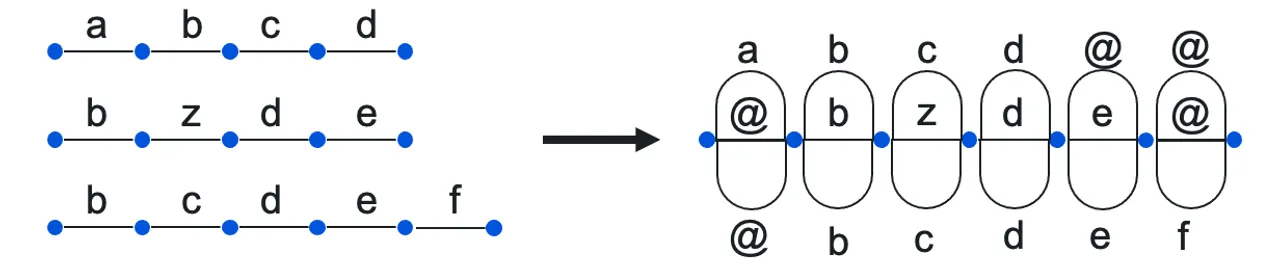
Finally, the aggregated sequence is the result of majority voting on each edge of the WTN.

We need to determine the tokenizer and detokenizer functions. For the tokenizer, we will split a sentence by spaces and for the detokenizer we will glue the words into a string

In [7]:
tokenizer = lambda s: s.split(" ")
detokenizer = lambda tokens: " ".join(tokens)

result_rover = ROVER(tokenizer, detokenizer).fit_predict(df)

In [8]:
result_rover.head()

task
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/0.mp3       young suit had been commanded to his mother's ...
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/1.mp3       there be an anxious interview mistress mr........
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/10.mp3           dismiss your squire robin and bit me evening
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/100.mp3                    it will be no disappointment to me
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/1000.mp3    i was thinking it's very like the ace of heart...
Name: agg_text, dtype: object

## TextRASA

The next method is *TextRASA*. The Reliability Aware Sequence Aggregation (RASA) algorithm consists of three steps:

Step 1. Encode the worker answers into embeddings.

Step 2. Estimate the global workers' reliabilities β by iteratively performing two steps:

For each task, estimate the aggregated embedding:
\begin{align}
        \hat{e}_i = \frac{\sum_{k} β_k e^k_i}{\sum_{k} β_k}
    \end{align}

 For each worker, estimate the global reliability:
\begin{align}
        β_k = \frac{χ^2_{(α/2,|ν_k|)}}{\sum_{i} (||e^k_i-\hat{e}_i||)},
    \end{align}

Where $ν_k$ is a set of tasks completed by the worker $k$.

​Step 3. Estimate the aggregated result. It is the output which embedding is the closest one to $\hat{e}_i$

We need to determine the encoder - a callable that takes a text and returns a NumPy array containing the corresponding embedding. For that, we will use the model from sentence_transformers. The model.encode returns the embedding.

In [ ]:
model = SentenceTransformer("all-mpnet-base-v2")

result_textrasa = TextRASA(encoder=model.encode).fit_predict(df)

In [10]:
result_textrasa.head()

,text
task,
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/0.mp3,young fitzu had been commanded to his mother's...
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/1.mp3,there be found an anxious interview me filthri...
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/10.mp3,dismiss your squire robin and bid me goody in
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/100.mp3,it will be no disappointment to me
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/1000.mp3,i was thinking it's very like the ace of heart...


## TextHRRASA

And the last one is *TextHRRASA*. The Hybrid Reliability and Representation Aware Sequence Aggregation (HRRASA) algorithm consists of four steps:

Step 1. Encode the worker answers into embeddings.

Step 2. Estimate the local workers' reliabilities that represent how well a worker responds to one particular task. The local reliability of the worker 
$k$ on the task $i$ is denoted by $γ_i^k$ and is calculated by incorporating both types of representations:

$γ^k_i = λ_{emb}γ^k_{i,emb} + λ_{seq}γ^k_{i,seq}, λ_{emb} + λ_{seq} = 1,$

where the $γ^k_{i,emb}$ value is a reliability calculated on embedding, and the $γ^k_{i,seq}$ value is a reliability calculated on output.
The $γ^k_{i,emb}$ value is calculated by the following equation:




where $U_i$ is a set of workers' responses on task $i$.

The $γ^k_{i,seq}$ value uses some similarity measure $sim$ on the output data, e.g. GLEU similarity on texts:

\begin{align}
        γ^k_{i,seq} = \frac{1}{|u_i|-1} \sum_{a^{k'}_i∈ u_i,k\neq k'} exp(\frac{||e^k_i-e^{k'}||^2}{||e^k_i||^2 ||e^{k'}_i||^2})
    \end{align}

Step 3. Estimate the global workers' reliabilities $β$ by iteratively performing two steps:

For each task, estimate the aggregated embedding:

\begin{align}
        \hat{e}_i= \frac{\sum_k γ^k_i β_k e^k_i}{\sum_k γ^k_i β_k}.
    \end{align}

For each worker, estimate the global reliability:


\begin{align}
        β_k = \frac{χ_{(a/2, |ν_k|)}}{\sum_i (||e^k_i - \hat{e}_i||^2/γ^k_i)}.
    \end{align}

Step 4. Estimate the aggregated result. It is the output which embedding is the closest one to  If calculate_ranks is true, the method also calculates ranks for each worker response as

\begin{align}
        s^k_i = β_k exp(\frac{||e^k_i-\hat{e}_i||^2}{||e^k_i||^2 ||\hat{e}_i||^2}) + γ^k_i.
    \end{align}


In [11]:
result_texthrrasa = TextHRRASA(encoder=model.encode).fit_predict(df)

In [12]:
result_texthrrasa.head()

,text
task,
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/0.mp3,young fitzu had been commanded to his mother's...
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/1.mp3,there be found an anxious interview me filthri...
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/10.mp3,dismiss your squire robin and bid me goody in
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/100.mp3,it will be no disappointment to me
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/1000.mp3,i was thinking it's very like the ace of heart...


## Comparing the results with WER

 Let's compare the results of these methods - we will use word error rate (*WER*) from jiwer. It is a common metric of the performance of an automatic speech recognition system. This value indicates the percentage of words that were incorrectly predicted. The lower the value, the better the performance of the ASR system with a WER of 0 being a perfect score. Word error rate can then be computed as:
\begin{align}
WER = \frac{S+D+I}{S+D+C},
\end{align}
Where: 
- S is the number of substitutions, is the number of deletions, 
- D is the number of deletions,
- I is the number of insertions, 
- C is the number of correct words.


Let's see the difference!

We need to sort out our golden set and result set. For this, we will arrange a target set and input set according to values with the same index.

WER calculation

In [72]:
print("The WER of TextRASA -", wer(gt.to_list(), result_textrasa["text"].to_list()))

print("The WER of TextHRRASA -", wer(gt.to_list(), result_texthrrasa["text"].to_list()))

print("The WER of ROVER -", wer(gt.to_list(), result_rover.to_list()))

The WER of TextRASA - 0.09051658551430311
The WER of TextHRRASA - 0.09378804017041996
The WER of ROVER - 0.06929017041996348


## Summary

We got extremely excellent results by all methods, as expected, the ROVER method gave a slightly better result. By the way, ROVER can even construct new transcriptions but RASA/HRRASA can only extract one from provided. So, if you do not sure what to use - try ROVER and be cool!


Thus, you have solved the problem posed - text aggregation - with the help of the Crowd-Kit library!